# Common Analysis for Kingman, Arizona

## Importing Packages

In [1]:
import pandas as pd
import seaborn as sns
import os, json, time
from pyproj import Transformer, Geod
from wildfire.Reader import Reader as WFReader
import geojson
import requests
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
# Considered warnings during analysis, suppressed them to clean notebook visually
warnings.filterwarnings("ignore")

## Data Acquisition

In this section, we acquire data from two sources. First, we acquire data collected by the the US Geological Survey on wildfires in the United States from the 1800s to present day. Second, we acquire data from the US EPA on air quality index information for stations close to Kingman, Arizona.

### Acquiring Wildfire Data

We start this acquisition by defining the path to the stored JSON file with the wildfire information. Also, we supply Kingman and its respective attributes.

In [59]:
DATA_FILENAME = '/Users/zach/Jupyter/DATA 512/project/USGS_Wildland_Fire_Combined_Dataset.json'
CITY_LOCATIONS = {
    'kingman' :     {'city'   : 'Kingman',
                       'latlon' : [35.1898, -114.0607]} 
}

Below we use the reader function to read in the JSON file into a list as dictionaries.

In [60]:
wfreader = WFReader(DATA_FILENAME)
feature_list = list()
# A rewind() on the reader object makes sure we're at the start of the feature list
# This way, we can execute this cell multiple times and get the same result 
wfreader.rewind()
# Now, read through each of the features, saving them as dictionaries into a list
feature = wfreader.next()
while feature:
    feature_list.append(feature)
    feature = wfreader.next()

Below we define a function to transform feature geometry data into a usable form to define the boundaries of each wildfire.

In [61]:
# Transform feature geometry data
# The function takes one parameter, a list of ESRI:102008 coordinates that will be transformed to EPSG:4326
# The function returns a list of coordinates in EPSG:4326
def convert_ring_to_epsg4326(ring_data=None):
    converted_ring = list()
    # We use a pyproj transformer that converts from ESRI:102008 to EPSG:4326 to transform the list of coordinates
    to_epsg4326 = Transformer.from_crs("ESRI:102008","EPSG:4326")
    # We'll run through the list transforming each ESRI:102008 x,y coordinate into a decimal degree lat,lon
    for coord in ring_data:
        lat,lon = to_epsg4326.transform(coord[0],coord[1])
        new_coord = lat,lon
        converted_ring.append(new_coord)
    return converted_ring

Below we define a function that returns the shortest distance from a point to a fire's perimeter.

In [62]:
# The function takes two parameters
#   A place - which is coordinate point (list or tuple with two items, (lat,lon) in decimal degrees EPSG:4326
#   Ring_data - a list of decimal degree coordinates for the fire boundary
# The function returns a list containing the shortest distance to the perimeter and the point where that is
def shortest_distance_from_place_to_fire_perimeter(place=None,ring_data=None):
    # Convert the ring data to the right coordinate system
    ring = convert_ring_to_epsg4326(ring_data)    
    # Create a epsg4326 compliant object - which is what the WGS84 ellipsoid is
    geodcalc = Geod(ellps='WGS84')
    closest_point = list()
    # Run through each point in the converted ring data
    for point in ring:
        # Calculate the distance
        d = geodcalc.inv(place[1],place[0],point[1],point[0])
        # Convert the distance to miles
        distance_in_miles = d[2]*0.00062137
        # If it's closer to the city than the point we have, save it
        if not closest_point:
            closest_point.append(distance_in_miles)
            closest_point.append(point)
        elif closest_point and closest_point[0]>distance_in_miles:
            closest_point = list()
            closest_point.append(distance_in_miles)
            closest_point.append(point)
    return closest_point

Here we iterate through the list of fire data, saving each fire and its respective data as a row in a new dataframe.

In [63]:
# Get a city from our CITY_LOCATIONS constant as our starting position
place = CITY_LOCATIONS['kingman']
# Define the dataframe
wf_df = pd.DataFrame(columns=['year', 'id', 'name', 'size', 'type', 'close_lat', 'close_lon', 'distance'])

# Iterate through the list and insert into the dataframe
for wf_feature in feature_list:
    try:
        wf_year = wf_feature['attributes']['Fire_Year']
        wf_id = wf_feature['attributes']['USGS_Assigned_ID']
        wf_name = wf_feature['attributes']['Listed_Fire_Names'].split(',')[0]
        wf_size = wf_feature['attributes']['GIS_Acres']
        wf_type = wf_feature['attributes']['Assigned_Fire_Type']
        ring_data = wf_feature['geometry']['rings'][0]
        # Using the distance function to calculate distance to fire from Kingman, Arizona
        wf_distance = shortest_distance_from_place_to_fire_perimeter(place['latlon'],ring_data)
        wf_df.loc[len(wf_df.index)] = [wf_year, wf_id, wf_name, wf_size, wf_type, wf_distance[1][0], wf_distance[1][1], wf_distance[0]]
    except:
        continue # Handles curved rings

Lastly, we save the dataframe as a csv to disk for later use. The code is commented out to avoid accidentally overwriting previously saved data with incomplete/incorrect data.

In [64]:
# wf_df.to_csv(r'/Users/zach/Jupyter/DATA 512/project/wf_data.csv', index=False)

### Acquiring AQI Data

Below we define the constants of our API request.

In [264]:
# CONSTANTS
# This is the root of all AQS API URLs
API_REQUEST_URL = 'https://aqs.epa.gov/data/api'
# These are 'actions' we can ask the API to take or requests that we can make of the API
# Sign-up request - generally only performed once - unless you lose your key
API_ACTION_SIGNUP = '/signup?email={email}'
# List actions provide information on API parameter values that are required by some other actions/requests
API_ACTION_LIST_CLASSES = '/list/classes?email={email}&key={key}'
API_ACTION_LIST_PARAMS = '/list/parametersByClass?email={email}&key={key}&pc={pclass}'
API_ACTION_LIST_SITES = '/list/sitesByCounty?email={email}&key={key}&state={state}&county={county}'
# Monitor actions are requests for monitoring stations that meet specific criteria
API_ACTION_MONITORS_COUNTY = '/monitors/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_MONITORS_BOX = '/monitors/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'
# Summary actions are requests for summary data. These are for daily summaries
API_ACTION_DAILY_SUMMARY_COUNTY = '/dailyData/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_DAILY_SUMMARY_BOX = '/dailyData/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'
# It is always nice to be respectful of a free data resource
# We're going to observe a 100 requests per minute limit - which is fairly nice
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED
# This is a template that covers most of the parameters for the actions we might take, from the set of actions
# above. In the examples below, most of the time parameters can either be supplied as individual values to a
# function - or they can be set in a copy of the template and passed in with the template.
AQS_REQUEST_TEMPLATE = {
    "email":      "",     
    "key":        "",      
    "state":      "",     # The two digit state FIPS # as a string
    "county":     "",     # The three digit county FIPS # as a string
    "begin_date": "",     # The start of a time window in YYYYMMDD format
    "end_date":   "",     # The end of a time window in YYYYMMDD format, begin_date and end_date must be in the same year
    "minlat":    0.0,
    "maxlat":    0.0,
    "minlon":    0.0,
    "maxlon":    0.0,
    "param":     "",     # A list of comma separated 5 digit codes, max 5 codes requested
    "pclass":    ""      # Parameter class is only used by the List calls
}

Here we define a function to implement a sign-up request

In [265]:
# This implements the sign-up request. The parameters are standardized so that this function definition matches
# all of the others. However, the easiest way to call this is to simply call this function with your preferred
# email address.
def request_signup(email_address = None,
                   endpoint_url = API_REQUEST_URL, 
                   endpoint_action = API_ACTION_SIGNUP, 
                   request_template = AQS_REQUEST_TEMPLATE,
                   headers = None):
    
    # Make sure we have a string - if you don't have access to this email addres, things might go badly for you
    if email_address:
        request_template['email'] = email_address        
    if not request_template['email']: 
        raise Exception("Must supply an email address to call 'request_signup()'")
    
    # Compose the signup url - create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # Make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

Here we make the sign-up request.

In [266]:
# A SIGNUP request is only to be done once, to request a key. A key is sent to that email address and needs to be confirmed with a click through
# This code should probably be commented out after you've made your key request to make sure you don't accidentally make a new sign-up request

# response = request_signup("zprice12@uw.edu")

We specify the constants for the API request using information from the sign-up request. We have changed the APIKEY for security reasons.

In [267]:
# You can specify these as constants for your own use - just don't distribute the notebook 
# without removing the constants
USERNAME = 'zprice12@uw.edu'
APIKEY = '$$$$$$$$'

We define a function to implement the list request on the US EPA API.

In [268]:
# This implements the list request. There are several versions of the list request that only require email and key.
# This code sets the default action/requests to list the groups or parameter class descriptors. Having those descriptors 
# allows one to request the individual (proprietary) 5 digit codes for individual air quality measures by using the
# param request. Some code in later cells will illustrate those requests.
def request_list_info(email_address = None, key = None,
                      endpoint_url = API_REQUEST_URL, 
                      endpoint_action = API_ACTION_LIST_CLASSES, 
                      request_template = AQS_REQUEST_TEMPLATE,
                      headers = None):
    
    #  Make sure we have email and key - at least
    #  This prioritizes the info from the call parameters - not what's already in the template
    if email_address:
        request_template['email'] = email_address
    if key:
        request_template['key'] = key
    
    # For the basic request we need an email address and a key
    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_list_info()'")
    if not request_template['key']: 
        raise Exception("Must supply a key to call 'request_list_info()'")

    # Compose the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # Make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

We define our parameters to narrow the censors we want, which pertain to AQI.

In [269]:
# Once we have a list of the classes or groups of possible sensors, we can find the sensor IDs that make up that class (group)
# The one that looks to be associated with the Air Quality Index is "AQI POLLUTANTS"
# We'll use that to make another list request.
AQI_PARAM_CLASS = "AQI POLLUTANTS"

We print the various sensors that pertain to AQI.

In [270]:
# Structure a request to get the sensor IDs associated with the AQI
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
# Here we specify that we want this 'pclass' or parameter classs
request_data['pclass'] = AQI_PARAM_CLASS  

response = request_list_info(request_template=request_data, endpoint_action=API_ACTION_LIST_PARAMS)

if response["Header"][0]['status'] == "Success":
    print(json.dumps(response['Data'],indent=4))
else:
    print(json.dumps(response,indent=4))

[
    {
        "code": "42101",
        "value_represented": "Carbon monoxide"
    },
    {
        "code": "42401",
        "value_represented": "Sulfur dioxide"
    },
    {
        "code": "42602",
        "value_represented": "Nitrogen dioxide (NO2)"
    },
    {
        "code": "44201",
        "value_represented": "Ozone"
    },
    {
        "code": "81102",
        "value_represented": "PM10 Total 0-10um STP"
    },
    {
        "code": "88101",
        "value_represented": "PM2.5 - Local Conditions"
    },
    {
        "code": "88502",
        "value_represented": "Acceptable PM2.5 AQI & Speciation Mass"
    }
]


We save the sensor codes for later use in our API request.

In [271]:
# Given the set of sensor codes, now we can create a parameter list or 'param' value as defined by the AQS API spec.
# It turns out that we want all of these measures for AQI, but we need to have two different param constants to get
# all seven of the code types. We can only have a max of 5 sensors/values request per param.
# Gaseous AQI pollutants CO, SO2, NO2, and O2
AQI_PARAMS_GASEOUS = "42101,42401,42602,44201"
#
#   Particulate AQI pollutants PM10, PM2.5, and Acceptable PM2.5
AQI_PARAMS_PARTICULATES = "81102,88101,88502"

We define Kingman and its relevant data to use in a later API request.

In [272]:
# We'll use these two city locations in the examples below.
CITY_LOCATIONS = {
    'kingman' :       {'city'   : 'kingman',
                       'county' : 'Mohave',
                       'state'  : 'Arizona',
                       'fips'   : '04015',
                       'latlon' : [35.1898, -114.0607] }
}

We print a list request to show all of the relevant sensors within Mohave County.

In [273]:
# This list request should give us a list of all the monitoring stations in the county specified by the
# given city selected from the CITY_LOCATIONS dictionary
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['state'] = CITY_LOCATIONS['kingman']['fips'][:2]   # The first two digits (characters) of FIPS is the state code
request_data['county'] = CITY_LOCATIONS['kingman']['fips'][2:]  # The last three digits (characters) of FIPS is the county code

response = request_list_info(request_template=request_data, endpoint_action=API_ACTION_LIST_SITES)

if response["Header"][0]['status'] == "Success":
    print(json.dumps(response['Data'],indent=4))
else:
    print(json.dumps(response,indent=4))

[
    {
        "code": "0001",
        "value_represented": null
    },
    {
        "code": "0006",
        "value_represented": "US BR DAVIS DAM"
    },
    {
        "code": "0007",
        "value_represented": "LAKE MOHAVE RESORT"
    },
    {
        "code": "0008",
        "value_represented": "WARDS PLUMBING SERV"
    },
    {
        "code": "0009",
        "value_represented": null
    },
    {
        "code": "0013",
        "value_represented": null
    },
    {
        "code": "0014",
        "value_represented": null
    },
    {
        "code": "0015",
        "value_represented": null
    },
    {
        "code": "1000",
        "value_represented": "Peach Springs"
    },
    {
        "code": "1001",
        "value_represented": null
    },
    {
        "code": "1003",
        "value_represented": "BULLHEAD CITY ADEQ"
    },
    {
        "code": "1004",
        "value_represented": "BULLHEAD CITY - SCE"
    },
    {
        "code": "1011",
        "value_represented

We define a function to get the daily summary for a set of sensors within a county.

In [274]:
# This implements the daily summary request. Daily summary provides a daily summary value for each sensor being requested
# from the start date to the end date. 
# Like the two other functions, this can be called with a mixture of a defined parameter dictionary, or with function
# parameters. If function parameters are provided, those take precedence over any parameters from the request template.
def request_daily_summary(email_address = None, key = None, param=None,
                          begin_date = None, end_date = None, fips = None,
                          endpoint_url = API_REQUEST_URL, 
                          endpoint_action = API_ACTION_DAILY_SUMMARY_COUNTY, 
                          request_template = AQS_REQUEST_TEMPLATE,
                          headers = None):
    
    # This prioritizes the info from the call parameters - not what's already in the template
    if email_address:
        request_template['email'] = email_address
    if key:
        request_template['key'] = key
    if param:
        request_template['param'] = param
    if begin_date:
        request_template['begin_date'] = begin_date
    if end_date:
        request_template['end_date'] = end_date
    if fips and len(fips)==5:
        request_template['state'] = fips[:2]
        request_template['county'] = fips[2:]            

    # Make sure there are values that allow us to make a call - these are always required
    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_daily_summary()'")
    if not request_template['key']: 
        raise Exception("Must supply a key to call 'request_daily_summary()'")
    if not request_template['param']: 
        raise Exception("Must supply param values to call 'request_daily_summary()'")
    if not request_template['begin_date']: 
        raise Exception("Must supply a begin_date to call 'request_daily_summary()'")
    if not request_template['end_date']: 
        raise Exception("Must supply an end_date to call 'request_daily_summary()'")
    # Note we're not validating FIPS fields because not all of the daily summary actions require the FIPS numbers
        
    # Compose the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # Make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

We make our API request to get the daily summaries for various sensors, these are saved in gaseous_aqi and particulate_aqi. Following this, we add the date and measured AQI for each daily summary to a new dataframe. Note, the API only allows for one year max of data in each request, so we used a loop to get all data from 1996 through October 2023. Also, note that the farthest the sensors go back in time for Mohave County is 1996. There is no data prior to this year. We did consider using bounding boxes to get data prior to 1996, but felt that enough data was present and wanted to keep a consistent source for the data over all the years.

In [275]:
# Defining the dataframe
aqi_df = pd.DataFrame(columns=['date', 'aqi'])

# Looping in one year intervals from 1996 through October 2023
for year in range(1996,2024):
    # Defining the start and end dates
    start_date = str(year)+'0101'
    if year == 2023:
        last_date = str(year)+'1031'
    else:
        last_date = str(year)+'1231'
    # Setting the parameters for the request
    request_data = AQS_REQUEST_TEMPLATE.copy()
    request_data['email'] = USERNAME
    request_data['key'] = APIKEY
    request_data['param'] = AQI_PARAMS_GASEOUS
    request_data['state'] = CITY_LOCATIONS['kingman']['fips'][:2]
    request_data['county'] = CITY_LOCATIONS['kingman']['fips'][2:]

    # Requesting daily summary data for a year
    gaseous_aqi = request_daily_summary(request_template=request_data, begin_date=start_date, end_date=last_date)

    request_data['param'] = AQI_PARAMS_PARTICULATES

    # Requesting daily summary data for a year
    particulate_aqi = request_daily_summary(request_template=request_data, begin_date=start_date, end_date=last_date)
    
    # Saving the gaseous data into the dataframe
    for i in range(len(gaseous_aqi['Data'])):
        date = gaseous_aqi['Data'][i]['date_local']
        aqi = gaseous_aqi['Data'][i]['aqi']
        aqi_df.loc[len(aqi_df.index)] = [date, aqi]
    
    # Saving the particulate data into the dataframe
    for i in range(len(particulate_aqi['Data'])):
        date = particulate_aqi['Data'][i]['date_local']
        aqi = particulate_aqi['Data'][i]['aqi']
        aqi_df.loc[len(aqi_df.index)] = [date, aqi]

We clean the AQI data to improve its usability. Note, we only use AQI measurements from May through October because this is fire season.

In [276]:
# Getting rid of AQI measurements that returned None
aqi_df['aqi'] = aqi_df['aqi'].astype('str')
aqi_df = aqi_df.loc[aqi_df['aqi'] != 'None']
# Filtering out fires outside of fire season based on month
aqi_df['date'] = pd.to_datetime(aqi_df['date'])
aqi_df['year'] = pd.DatetimeIndex(aqi_df['date']).year
aqi_df['month'] = pd.DatetimeIndex(aqi_df['date']).month
aqi_df = aqi_df.loc[(aqi_df['month']>=5) & (aqi_df['month']<=10)]
# Changing datatype of AQI back to float
aqi_df['aqi'] = aqi_df['aqi'].astype('float')

We estimate the AQI for Kingman, Arizona for each year from 1996-2023 by grouping over year and calculating the average of each year's AQI measurements over all sensors in Mohave County.

In [280]:
aqi_df = aqi_df.groupby('year', as_index='False')['aqi'].mean().reset_index()

We save the AQI dataframe as a csv to disk for later use. We comment this out to avoid overwriting data accidentally.

In [281]:
# aqi_df.to_csv(r'/Users/zach/Jupyter/DATA 512/project/aqi_data.csv', index=False)

## Predictive Model for Smoke Estimates

In this section, we define a smoke estimate and use a time series to predict smoke impact for Kingman, Arizona from 2021-2049.

### Defining the Smoke Estimate

We read the data back in for the fires.

In [2]:
wf_df = pd.read_csv('/Users/zach/Jupyter/DATA 512/project/common_analysis/wf_data.csv')

We filter to only include fires from 1963 on and only those that were within 1250 miles of Kingman, Arizona.

In [3]:
wf_df = wf_df.loc[(wf_df['year']>=1963) & (wf_df['distance']<=1250)]

We define our annual smoke estimate. This is done by first dividing the size of the fire by the distance it was from Kingman, Arizona. This provides a fairly good smoke estimate because a larger fire increases the smoke estimate and a closer fire increases the smoke estimate. We then grouped by year and summed to get an annual smoke estimate. This was then scaled by 184 because that's how many days fire season is and it helps put the measurement on the same order of magnitude as our AQI values.

In [4]:
wf_df['smoke_impact'] = (wf_df['size']/wf_df['distance'])
wf_grp = wf_df.groupby('year', as_index='False')['smoke_impact'].sum().reset_index()
wf_grp['smoke_impact'] = wf_grp['smoke_impact']/184

### Building the Time Series

Below we prepare the data for the time series by converting the year to a datetime object and setting it as the index.

In [5]:
wf_grp['year'] = pd.to_datetime(wf_grp['year'], format='%Y')
wf_grp = wf_grp.set_index('year')

We fit the model using an ARIMA time series and then get predictions from 2021 through 2049. We also calculate and save the 95% confidence intervals for each prediction. 

In [6]:
mod = sm.tsa.statespace.SARIMAX(wf_grp['smoke_impact'], trend='ct', order=(1,1,1))
res = mod.fit(disp=False)
preds_df = (res.get_prediction(start='2021-01-01', end='2049-12-31').summary_frame(alpha=0.05))

We graph the time series, showing the observed values and the predicted values from 2021 through 2049.

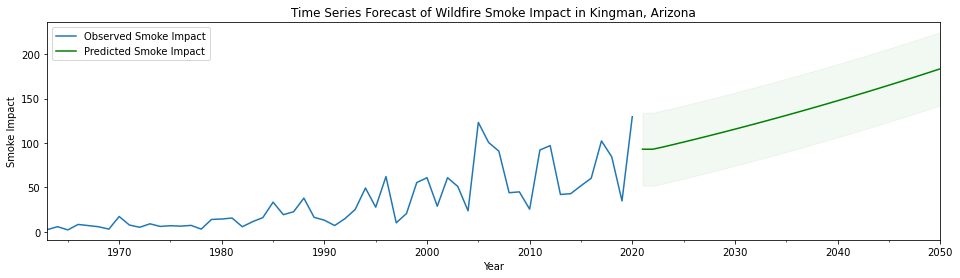

In [7]:
fig, ax = plt.subplots(figsize=(16,4))
ax = wf_grp['smoke_impact'].plot(label='Observed Smoke Impact')
ax.set(title='Time Series Forecast of Wildfire Smoke Impact in Kingman, Arizona', xlabel='Year', ylabel='Smoke Impact')
preds_df['mean'].plot(ax=ax, style='g', label='Predicted Smoke Impact')
ax.fill_between(preds_df.index, preds_df['mean_ci_lower'], preds_df['mean_ci_upper'], color='g', alpha=0.05)
legend = ax.legend(loc='upper left')
plt.show()

## Visualizations

In this section, we provide three helpful visualizations to give further insight into the fire data.

### Number of Fires Occurring Every 50 Mile Distance from Kingman, Arizona

We create a histogram to show the total number of fires that occurred within every 50 mile increment from Kingman, Arizona from 1963 through 2020.

Text(0, 0.5, 'Number of Fires')

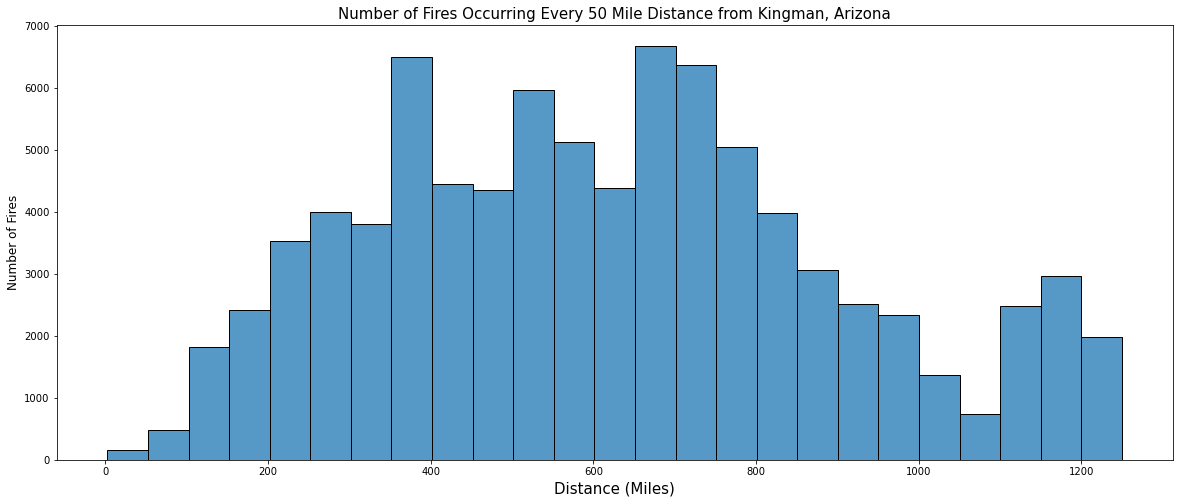

In [10]:
sns.histplot(data=wf_df, x='distance', bins=25)
plt.rcParams["figure.figsize"] = (20,8)
plt.title('Number of Fires Occurring Every 50 Mile Distance from Kingman, Arizona', fontsize=15)
plt.xlabel('Distance (Miles)', fontsize=15)
plt.ylabel('Number of Fires', fontsize=12)

### Total Acres Burned per Year within 1250 Miles of Kingman, Arizona

We create a time series to show the total acres burned per year by fires within 1250 miles of Kingman, Arizona.

Text(0, 0.5, 'Total Acres Burned')

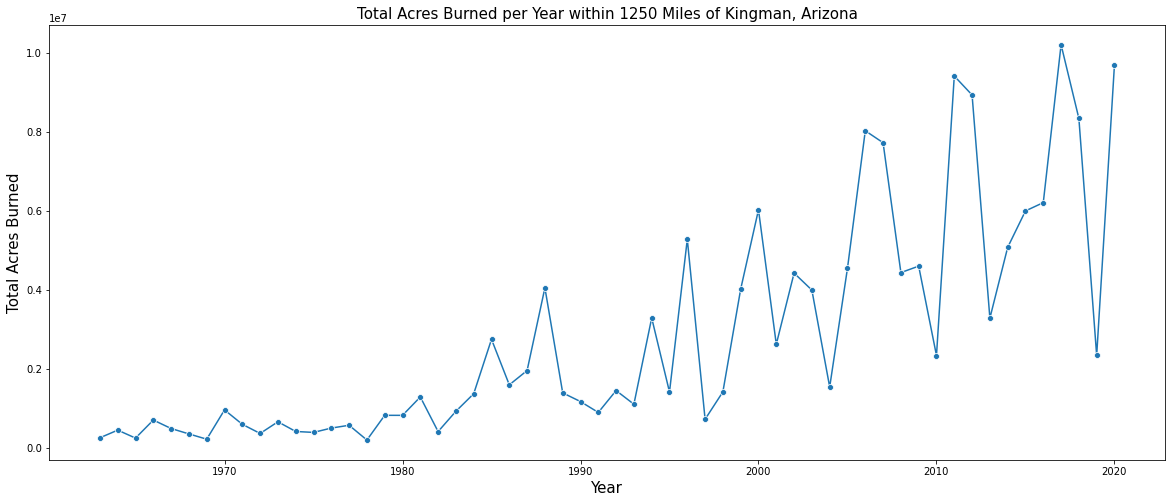

In [11]:
wf_grp_viz2 = wf_df.groupby('year', as_index='False')['size'].sum().reset_index()
sns.lineplot(data=wf_grp_viz2, x='year', y='size', marker='o')
plt.rcParams["figure.figsize"] = (20,8)
plt.title('Total Acres Burned per Year within 1250 Miles of Kingman, Arizona', fontsize=15)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Total Acres Burned', fontsize=15)

### Smoke Estimate vs AQI Estimate for Kingman, Arizona

We load the AQI data that was previously saved to disk.

In [12]:
aqi_df = pd.read_csv('/Users/zach/Jupyter/DATA 512/project/common_analysis/aqi_data.csv')

We create a time series showing our smoke estimate from 1963 through 2020 and the AQI smoke estimate from 1996 through 2020 for comparison.

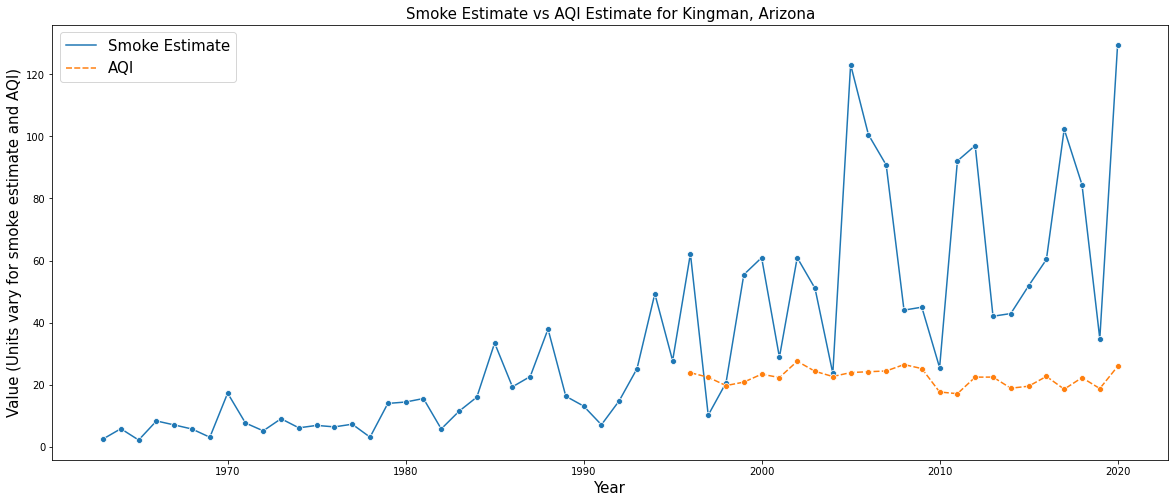

In [13]:
# Group the fire data by year and calculate the annual smoke impact estimate
wf_grp_viz3 = wf_df.groupby('year', as_index='False')['smoke_impact'].sum().reset_index()
wf_grp_viz3['smoke_impact'] = wf_grp_viz3['smoke_impact']/184
# Filter the AQI data to include years only up to 2020
aqi_df = aqi_df.loc[aqi_df['year']<=2020]
# Join the smoke estimate and AQI estimate data for plotting
est_aqi_grp = wf_grp_viz3.merge(aqi_df, on=['year'], how='left')
est_aqi_grp = est_aqi_grp.set_index('year')
est_aqi_grp = est_aqi_grp.rename(columns={'smoke_impact': 'Smoke Estimate', 'aqi': 'AQI'})
sns.lineplot(data=est_aqi_grp, marker='o')
plt.rcParams["figure.figsize"] = (20,8)
plt.title('Smoke Estimate vs AQI Estimate for Kingman, Arizona', fontsize=15)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Value (Units vary for smoke estimate and AQI)', fontsize=15)
plt.legend(fontsize=15)

We create a time series of just smoke estimate.

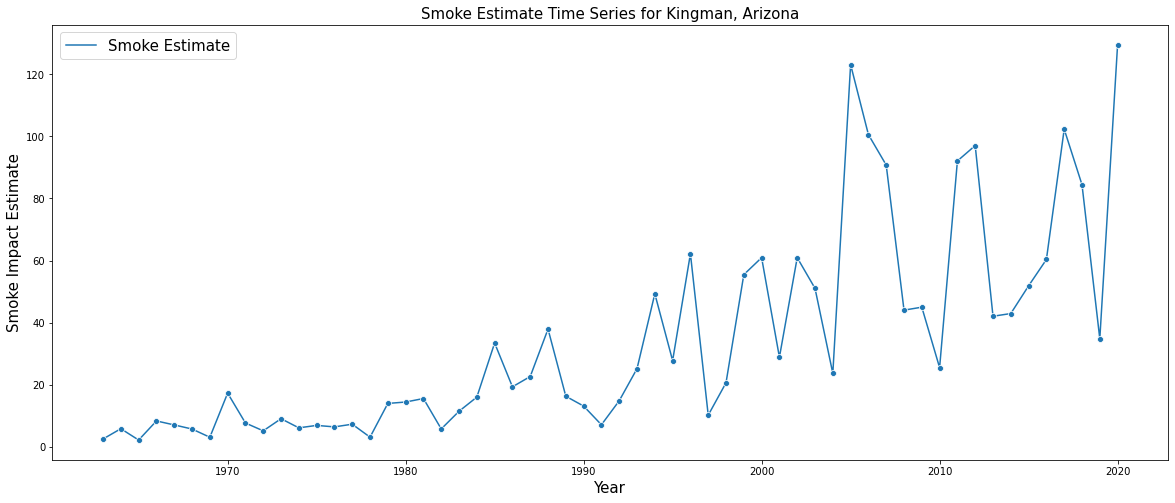

In [14]:
# Group the fire data by year and calculate the annual smoke impact estimate
wf_grp_viz4 = wf_df.groupby('year', as_index='False')['smoke_impact'].sum().reset_index()
wf_grp_viz4['smoke_impact'] = wf_grp_viz4['smoke_impact']/184
wf_grp_viz4 = wf_grp_viz4.set_index('year')
wf_grp_viz4 = wf_grp_viz4.rename(columns={'smoke_impact': 'Smoke Estimate'})
sns.lineplot(data=wf_grp_viz4, marker='o')
plt.rcParams["figure.figsize"] = (20,8)
plt.title('Smoke Estimate Time Series for Kingman, Arizona', fontsize=15)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Smoke Impact Estimate', fontsize=15)
plt.legend(fontsize=15)

We create a time series of just AQI.

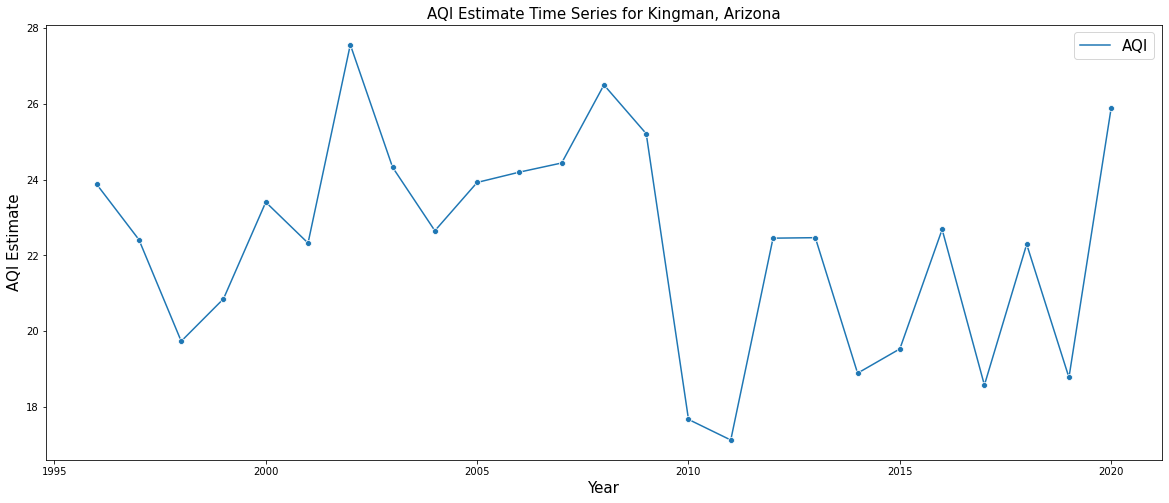

In [15]:
# Group the fire data by year and calculate the annual smoke impact estimate
wf_grp_viz5 = wf_df.groupby('year', as_index='False')['smoke_impact'].sum().reset_index()
wf_grp_viz5['smoke_impact'] = wf_grp_viz5['smoke_impact']/184
# Filter the AQI data to include years only up to 2020
aqi_df = aqi_df.loc[aqi_df['year']<=2020]
# Join the smoke estimate and AQI estimate data for plotting
est_aqi_grp = wf_grp_viz5.merge(aqi_df, on=['year'], how='left')
est_aqi_grp = est_aqi_grp.set_index('year')
est_aqi_grp = est_aqi_grp.rename(columns={'smoke_impact': 'Smoke Estimate', 'aqi': 'AQI'})
est_aqi_grp = est_aqi_grp.drop(['Smoke Estimate'], axis=1)
sns.lineplot(data=est_aqi_grp, marker='o')
plt.rcParams["figure.figsize"] = (20,8)
plt.title('AQI Estimate Time Series for Kingman, Arizona', fontsize=15)
plt.xlabel('Year', fontsize=15)
plt.ylabel('AQI Estimate', fontsize=15)
plt.legend(fontsize=15)